# Análisis de Redes Sociales: Festival de Eurovisión

**Integrantes:** Araceli Pérez Buendía. Sofía Maceín Sanz

Bibliografía básica: https://www.kaggle.com/code/jeleandro/network-analysis-applied-to-eurovision

## Índice

1. Introducción
2. Resumen y objetivos
3. Análisis exploratorio de los datos

### 1. Introducción

### 2. Resumen y objetivos

### 3. Análisis exploratorio de los datos

Antes de comenzar, haremos una exploración previa de los datos por si fuera mecesario hacer modificaciones o transformaciones.

####  Paquetes y librerías

In [1]:
# Paquetes y librerias
import numpy as np 
import pandas as pd 
import pylab as plt
import seaborn as sns
import pprint
from IPython.display import HTML

%matplotlib inline
sns.set_style('whitegrid')

#### 3.1. Carga de los datos y preliminares

En primer lugar, cargamos los datos y miramos la dimensión y la estructura.

In [2]:
# Dataset de eurovision
df = pd.read_excel('eurovision_1975_2019.xlsx')
df.columns = ['year','final','edition','votetype','countryfrom','countryto','points','duplicate'];

# Visualizacion dataset
df.sample(5)

,year,final,edition,votetype,countryfrom,countryto,points,duplicate
2107,1980,f,1980f,J,Turkey,Sweden,8,NaN
6143,1990,f,1990f,J,Sweden,France,5,NaN
24239,2009,sf1,2009sf1,J,Armenia,Sweden,8,NaN
5926,1990,f,1990f,J,Germany,Iceland,0,NaN
39681,2017,f,2017f,J,Portugal,Norway,2,NaN


In [3]:
# Dimension de los datos
df.shape

(49832, 8)

Tenemos 49832 registros de 8 variables.

In [4]:
# Valores de las columnas
for col in df.columns:
    print(col, ': ', sorted(df[col].dropna().unique()), '\n')

year :  [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] 

final :  ['f', 'sf', 'sf1', 'sf2'] 

edition :  ['1975f', '1976f', '1977f', '1978f', '1979f', '1980f', '1981f', '1982f', '1983f', '1984f', '1985f', '1986f', '1987f', '1988f', '1989f', '1990f', '1991f', '1992f', '1993f', '1994f', '1995f', '1996f', '1997f', '1998f', '1999f', '2000f', '2001f', '2002f', '2003f', '2004f', '2004sf', '2005f', '2005sf', '2006f', '2006sf', '2007f', '2007sf', '2008f', '2008sf1', '2008sf2', '2009f', '2009sf1', '2009sf2', '2010f', '2010sf1', '2010sf2', '2011f', '2011sf1', '2011sf2', '2012f', '2012sf1', '2012sf2', '2013f', '2013sf1', '2013sf2', '2014f', '2014sf1', '2014sf2', '2015f', '2015sf1', '2015sf2', '2016f', '2016sf1', '2016sf2', '2017f', '2017sf1', '2017sf2', '2018f', '2018sf1', '20

In [5]:
df.sample(5)

,year,final,edition,votetype,countryfrom,countryto,points,duplicate
2226,1981,f,1981f,J,Finland,Switzerland,12,NaN
714,1977,f,1977f,J,Belgium,Norway,5,NaN
30309,2012,sf2,2012sf2,J,Turkey,Bosnia & Herzegovina,12,NaN
22145,2008,f,2008f,J,Slovenia,Finland,0,NaN
49110,2019,f,2019f,J,The Netherlands,Albania,0,NaN


Las variables del dataset son las siguientes:

*   ***year*** : Representa el año en que ocurrió el concurso. Los valores varían desde 1975 hasta 2019.
*   ***final*** : Indica si el registro corresponde a la final o a una de las semifinales del concurso.
*   ***edition*** : Representa la edición específica del evento de Eurovisión, indicada por el año y el tipo de ronda (final o semifinal).
*   ***votetype*** : Indica el tipo de voto utilizado en el evento, donde "J" representa el voto del jurado y "T" representa el televoto.
*   ***countryfrom*** : Indica el país de origen del voto.
*   ***countryto*** : Indica el país al que se dirige el voto.
*   ***points*** : Representa la cantidad de puntos asignados por un país a otro durante el proceso de votación. Los valores pueden variar entre 0 y 12.
*   ***duplicate*** : Esta variable marca con "x" aquellas filas donde el país de origen y el país de destino son iguales.

Vemos el tipo de variables y si existen valores nulos.

In [6]:
# Tipo de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49832 entries, 0 to 49831
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         49832 non-null  int64 
 1   final        49832 non-null  object
 2   edition      49832 non-null  object
 3   votetype     49832 non-null  object
 4   countryfrom  49832 non-null  object
 5   countryto    49832 non-null  object
 6   points       49832 non-null  int64 
 7   duplicate    1528 non-null   object
dtypes: int64(2), object(6)
memory usage: 3.0+ MB


A continuación,

* Eliminamos del dataset los países que no están conectados dado un año, es decir, aquellos con puntuación `points` $ = 0$.
* Eliminamos las entradas marcadas como duplicadas, `duplicates` = 'x', que corresponenden a la unión del país consigo mismo.
* Renombramos algunos países para mayor facilidad
* Como para la construcción de la red final se tendrá en cuenta las ediciones a partir del año 2000, debido la incorporacion del televoto y la estabilidad política de los países, vamos a considerar los votos de Yugoslavia en sus correspondendientes estados actuales tras la disolución en 1992 (Bosnia y Herzegovina, Croacia, Eslovenia, Macedonia del Norte, Montenegro, Serbia, Kosovo).
* Eliminamos aquellos países con una baja participación, en particular, menor a 5 años o que no haya participado en los úlitmos 8 años.

Para todo esto, definimos una función `basicClean` en la que aplicamos los procedimientos explicados.

In [7]:
def basicClean(df, minYears = 5, last_participation = 8):

    # 1. ELiminamos puntuaciones de 0
    df2 = df.copy().query('points > 0')

    # 2. Eliminamos duplicados
    # Convertimos los valores 'x' a True y el resto a False
    df2['duplicate'] = df2['duplicate'].apply(lambda x: True if x == 'x' or x == True else False)
    # Nos quedamos con las filas en las que duplicate toma el valor False
    df2 = df2.query('duplicate == False').drop(columns=['duplicate'])


    # 3. Renombramos paises
    def applyRename(x):
        # Creamos un diccionario con los paises a renombrar
        renamings = {
            'North Macedonia': 'Macedonia',
            'F.Y.R. Macedonia': 'Macedonia',
            'The Netherands': 'Netherlands', # debido a un error en los datos
            'The Netherlands': 'Netherlands',
            'Bosnia & Herzegovina': 'Bosnia'}
        # Si el pais esta entre los paises del diccionario, cambiamos el nombre;
        # en caso contrario se devuelve el mismo nombre
        return renamings[x] if x in renamings else x

    # Aplicamos la funcion a las columnas con ls paises
    df2['countryfrom'] = df2['countryfrom'].apply(applyRename)
    df2['countryto']   = df2['countryto'].apply(applyRename)


    # 4. Division de Yugoslavia y Serbia & Montenegro a sus estados en la actualidad
    division = {
        'Yugoslavia': ['Macedonia', 'Serbia', 'Montenegro', 'Slovenia', 'Bosnia','Croatia'],
        'Serbia & Montenegro': ['Serbia', 'Montenegro']}

    df2['countryfrom'] = df2['countryfrom'].apply(lambda x:division[x] if x in division else x)
    df2['countryto']   = df2['countryto'].apply(lambda x:division[x] if x in division else x)

    df2 = df2.explode('countryfrom').explode('countryto')
    # Cada cambio que involucre a varios paises se desglosa entre los
    # pares de paises correspondientess


    # 5. Eliminamos aquellos paises que hayan participado menos 5 veces
    # y que no han estado activos en los ultimos 5 años

    # Calculamos numero de años participados y cuantos años han pasado desde
    # utlima participacion
    toKeep = df2.groupby('countryfrom').apply(lambda x:pd.Series(
        {'years': x['year'].nunique(),
        'last_participation': df2['year'].max() - x['year'].max()
    })).query(f'years >= {minYears} and last_participation <= {last_participation}').reset_index()['countryfrom']
    # Asi obtenemos la lista de paises que cumplen los requisitos

    # Mostramos los paises que no cumplen los requisitos
    display(HTML("<p>ignored countries: %s</p>" %', '.join(df2[df2['countryfrom'].isin(toKeep)==False]['countryfrom'].unique())))

    df2 = df2[df2['countryfrom'].isin(toKeep)]
    df2 = df2[df2['countryto'].isin(toKeep)]



    # 6. Tomamos los puntos unicamente de la final
    df2['finalcode'] = df2.final.map({'f':1, 'sf':2,'sf1':2,'sf2':2})
    temp1 = df2.groupby(['countryto','year']).agg({'finalcode':'min'});
    df2 = pd.merge(df2,temp1, on=['countryto','year','finalcode'], how='inner')

    assert len(df2.groupby(['countryfrom','countryto','year']).agg({'final':'nunique'}).query('final >1')) == 0

    df2.drop(columns=['finalcode','edition'], inplace=True)

    return df2.reindex()

In [8]:
# Aplicamos la funcion al dataset original
df2 = basicClean(df)

# Dimnesion del nuevo dataset
print('Dimension del nuevo dataset: ', df2.shape, '\n')

# Visualizacion del dataset
df2.sample(5)

Dimension del nuevo dataset:  (17199, 6) 



,year,final,votetype,countryfrom,countryto,points
1384,1982,f,J,Macedonia,Israel,3
2425,1986,f,J,Iceland,Slovenia,5
12283,2014,f,J,Montenegro,Belarus,1
7204,2004,f,J,Montenegro,Sweden,4
11909,2013,f,J,Austria,Ukraine,1


Ahora tenemos un dataset con 17199 registros y 6 variables.

#### 3.2. Análisis exploratorio de los datos

El objetivo de esta sección es estudiar la posible distribución subyecente de los datos, así como posibles outliers o valores atípicos. Con ello, pretendemos crear una red que recoja la información básica del concurso a lo largo de los años para dar respuesta a las preguntas planteadas.

In [ ]:
# Dataset
df2.sample(5)

**1) Participación a lo largo de los años:** Gráfico del número de puntos totales que se han dado a lo largo de los años en la categoría de final. Tratamos de comprender el crecimiento de Eurovisión y el interés de los países a lo largo del tiempo.

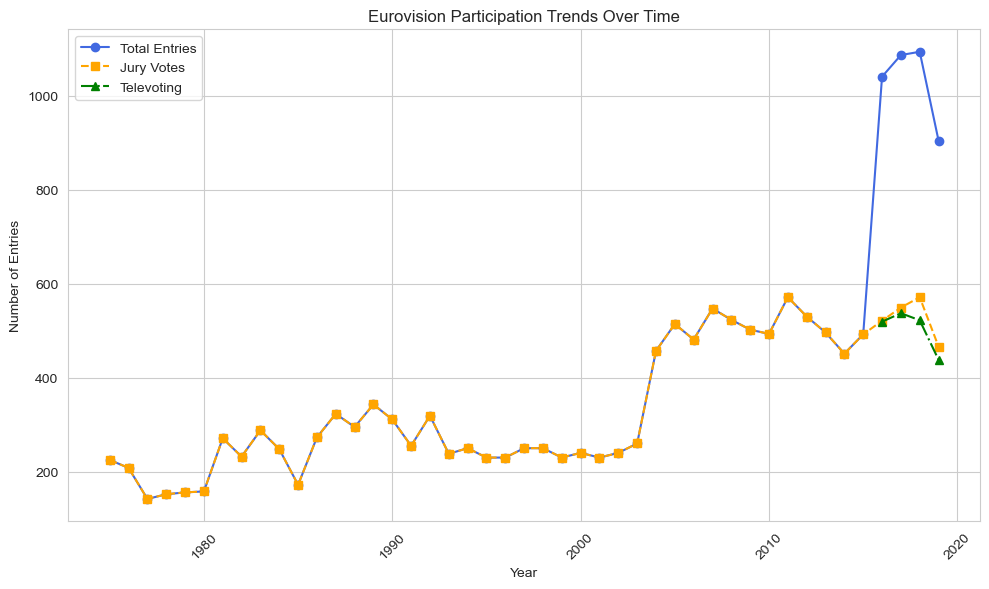

In [9]:
# Convertimos la columna 'year' a formato datetime
df2['year'] = pd.to_datetime(df2['year'], format='%Y')

# Agrupamos por año y contamos el número de entradas
participation_counts_total = df2.groupby(df2['year'].dt.year).size() # totales
participation_counts_J = df2[df2['votetype'] == 'J'].groupby(df2['year'].dt.year).size() # jurado
participation_counts_T = df2[df2['votetype'] == 'T'].groupby(df2['year'].dt.year).size() # televoto

# Grafico de las tendencias de participación
plt.figure(figsize=(10, 6))

participation_counts_total.plot(marker='o', color='royalblue', linestyle='-', label='Total Entries')
participation_counts_J.plot(marker='s', color='orange', linestyle='--', label='Jury Votes')
participation_counts_T.plot(marker='^', color='green', linestyle='-.', label='Televoting')

plt.title('Eurovision Participation Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Breve explicación del aumento de votos:

* 1997-2008: Televoto
* 2009-2015: Sistema Mixto
* 2016 - Televoto(app)

Podemos observar que a partir de principios de la década de los 2000 hay un aumento significativo en la participación.

**2) Distribución de puntos por país:** Histograma que visualiza la distribución de puntos recibidos por cada país. Esto puede proporcionar información sobre la equidad y consistencia del proceso de votación.

<Figure size 1200x800 with 0 Axes>

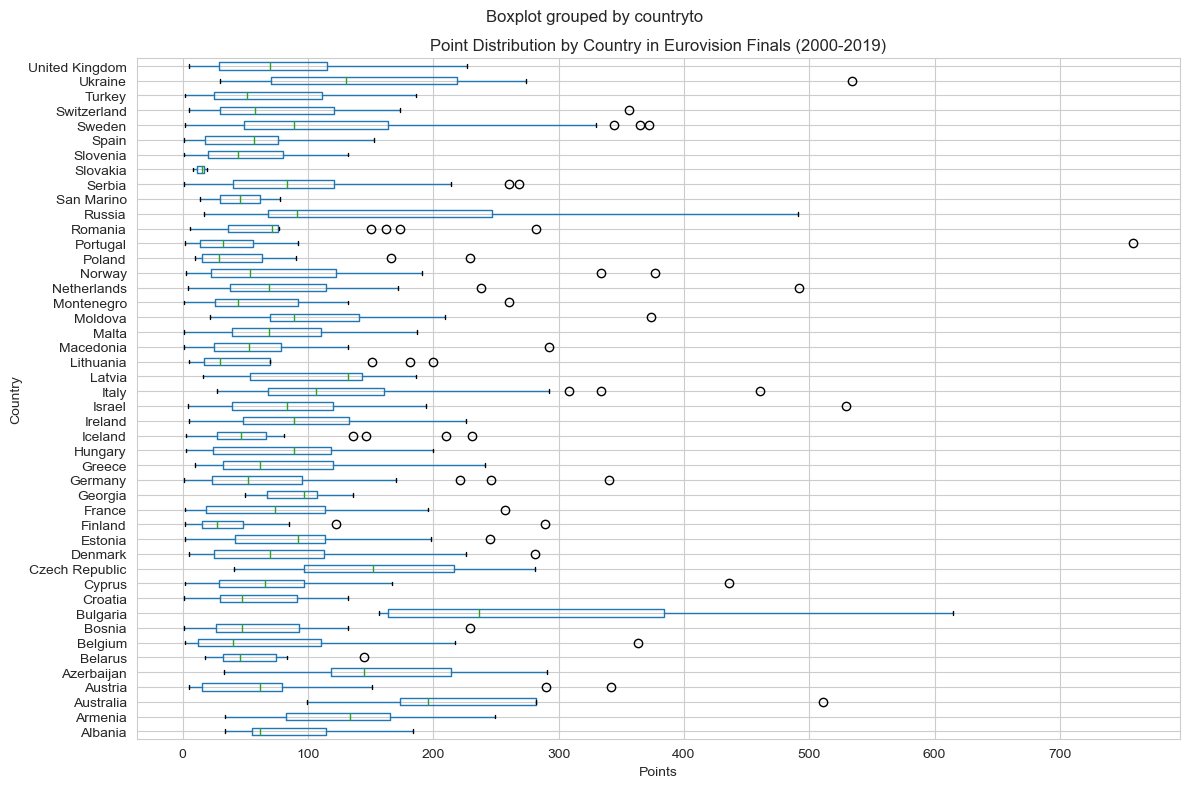

In [10]:
# Categoria de final (f)
df_final = df2[df2['final'] == 'f']
points_by_country_year = df_final.groupby(['countryto', df_final['year'].dt.year])['points'].sum().reset_index()

# Grafico boxplot
plt.figure(figsize=(12, 8))
boxplot = points_by_country_year.boxplot(column='points', by='countryto', vert=False, figsize=(12,8))

plt.title('Point Distribution by Country in Eurovision Finals (2000-2019)')
plt.xlabel('Points')
plt.ylabel('Country')
plt.grid(True)
plt.tight_layout()
plt.show()

En algunos países se observa una variabilidad considerable en la cantidad de puntos recibidos a lo largo de los años. Lo que significa que algunos años han sido más favoralbes en términos de puntuación recibida, y otros años menos favorables.

**3) Mapa de calor del intercambio de puntos:** Tratamos de ver patrones de alianzas/amistades entre países e identificar grupos de países que a menudo se votan entre sí.

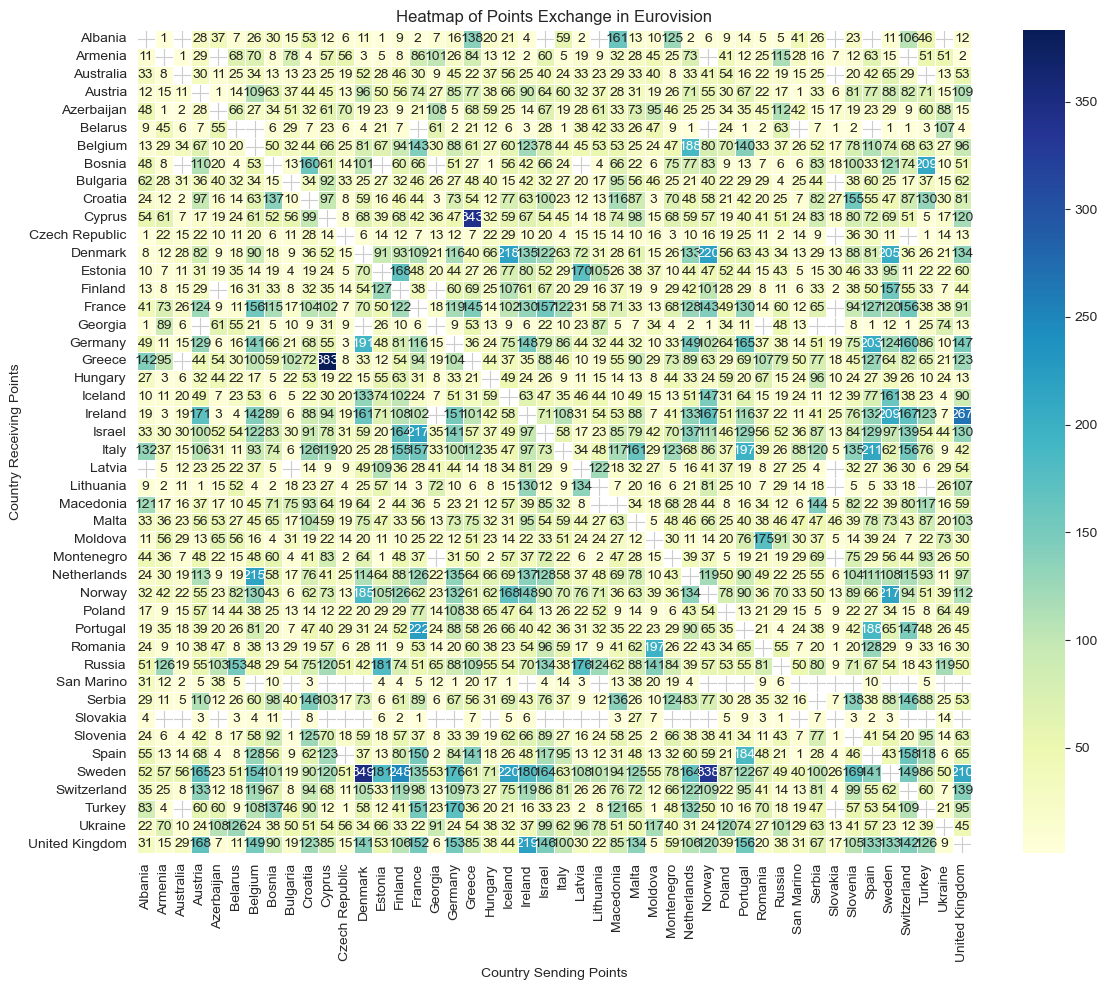

In [11]:
# Intercambio de puntos
points_matrix = df2.pivot_table(index='countryto', columns='countryfrom', values='points', aggfunc='sum')

# Grafico
plt.figure(figsize=(12, 10))
sns.heatmap(points_matrix, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5)
plt.title('Heatmap of Points Exchange in Eurovision')
plt.xlabel('Country Sending Points')
plt.ylabel('Country Receiving Points')
plt.tight_layout()
plt.show()

Se observan correlaciones positivas significativas entre ciertos países, como Serbia y Bosnia, y España y Portugal, lo que sugiere una tendencia a votarse mutuamente.

Hay grupos de países con correlaciones positivas entre ellos, como los países de los Balcanes (Serbia, Bosnia, Montenegro y Macedonia) y los países escandinavos (Suecia, Noruega y Dinamarca), lo que indica posibles patrones regionales o culturales en la votación.

**4) Resumen de la participación por país en el concurso de Eurovisión**: incluyendo el número de años únicos en los que un país participó, el año más temprano de participación, el año más reciente de participación y el porcentaje de presencia, que representa la proporción de años en los que el país participó en relación con el número total de años disponibles.

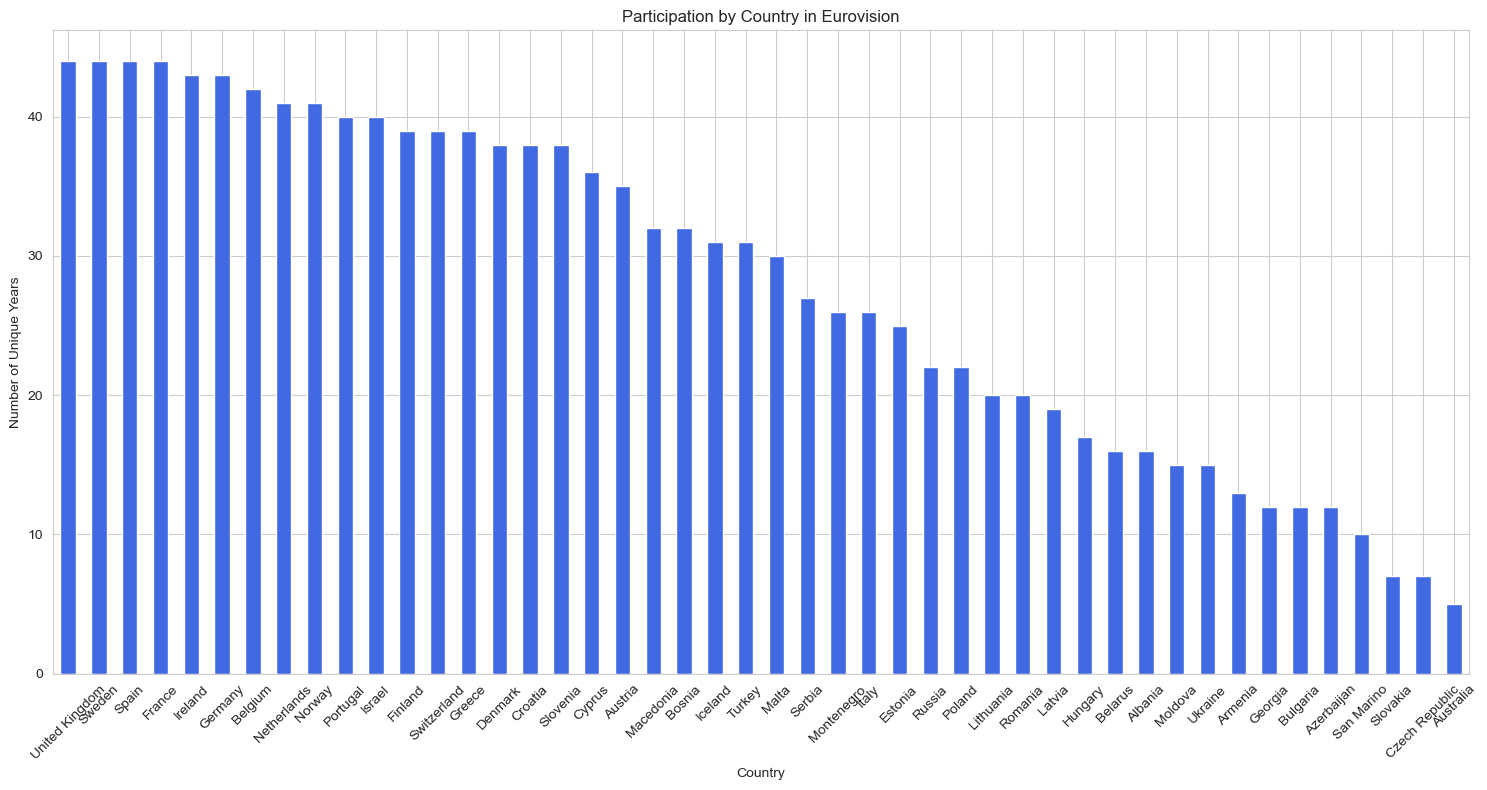

In [12]:
# Generate the summary of participation by country
participation_summary = df2.groupby(['countryto']).apply(lambda x: pd.Series({
    'nyear': x['year'].nunique(),
    'min_year': x['year'].min().year,
    'max_year': x['year'].max().year,
    'presence': int(100 * x['year'].nunique() / (x['year'].max().year - x['year'].min().year + 1))
}))

# Sort the summary by the number of unique years in descending order
participation_summary_sorted = participation_summary.sort_values('nyear', ascending=False)# Plot the participation by country as a bar chart
plt.figure(figsize=(15, 8))
participation_summary_sorted['nyear'].plot(kind='bar', color='royalblue')
plt.title('Participation by Country in Eurovision')
plt.xlabel('Country')
plt.ylabel('Number of Unique Years')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Podemos observar que algunos países, como Reino Unido, Suecia, España y Francia, han participado en casi todas las ediciones del concurso desde que comenzó en 1975.

Otros países, como Australia, han participado en un número menor de ediciones debido a su incorporación más reciente al concurso. Sin embargo, su tasa de presencia es del 100% en las ediciones en las que han participado.

Algunos países han disminuido su participación a lo largo de los años, como Turquía, que dejó de participar después de 2012, y Bosnia, que dejó de participar después de 2016. Esto puede deberse a varias razones, como cambios en las políticas de participación o problemas financieros.

**Winners**

In [13]:
#The Winner
df2.query('final =="f"')\
    .groupby(['countryto','year']).agg({'points':'sum'}).reset_index()\
    .groupby('year').apply(lambda x:x.sort_values('points').tail(1)).reset_index(drop=True)\
    .sort_values('year',ascending=False)\
    .head(12).T.style.set_caption("The Winners").hide_index()\
    #.bar(subset=['points'], color='#d65f5f')

C:\Users\sofia\AppData\Local\Temp\ipykernel_14332\2000270484.py:6: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  .head(12).T.style.set_caption("The Winners").hide_index()\


44,43,42,41,40,39,38,37,36,35,34,33
Netherlands,Israel,Portugal,Ukraine,Sweden,Austria,Denmark,Sweden,Azerbaijan,Germany,Norway,Russia
2019-01-01 00:00:00,2018-01-01 00:00:00,2017-01-01 00:00:00,2016-01-01 00:00:00,2015-01-01 00:00:00,2014-01-01 00:00:00,2013-01-01 00:00:00,2012-01-01 00:00:00,2011-01-01 00:00:00,2010-01-01 00:00:00,2009-01-01 00:00:00,2008-01-01 00:00:00
492,529,758,534,365,290,281,372,221,246,377,267


**Frecuencia con la que cada país aparece en la lista de los mejores países de Eurovisión en función de la cantidad de puntos recibidos en cada año y el número de posiciones superiores**

In [14]:
def atTop(df,tops):
    #points received
    df= df.groupby(['countryto','year']).agg({'points':'sum'}).reset_index().groupby('year')

    #top1 (country with most of points)
    top = df.apply(lambda x:x.sort_values('points').tail(1)).reset_index(drop=True)\
        .groupby('countryto').agg({'year':'nunique'}).rename(columns={'year':'years_on_top'}).reset_index()

    #the other tops
    for t in tops:
        temp = df.apply(lambda x:x.sort_values('points').tail(t)).reset_index(drop=True)\
            .groupby('countryto').agg({'year':'nunique'})\
            .rename(columns={'year':f'years_on_top_{t}'}).reset_index()
        top = pd.merge(top,temp, on='countryto',how='outer')

    top = top.fillna(0);
    floatcols = top.columns[top.dtypes == 'float64']
    top[floatcols] = top[floatcols].astype(int)

    return top

In [15]:
dfAtTop = atTop(df2.query('final =="f"'), tops=[3,5,7,10])
dfAtTop.sort_values(['years_on_top','years_on_top_3'], ascending=[False,False]).head(20)\
    .style.bar(subset=['years_on_top','years_on_top_3','years_on_top_5','years_on_top_7','years_on_top_10'],
               color='#cccccc')

,countryto,years_on_top,years_on_top_3,years_on_top_5,years_on_top_7,years_on_top_10
18,Sweden,5,12,19,25,29
9,Ireland,5,10,15,19,22
10,Israel,5,7,10,12,19
22,United Kingdom,4,10,15,18,23
6,France,3,6,12,16,21
14,Norway,3,5,10,11,16
7,Germany,2,8,12,14,21
21,Ukraine,2,5,6,8,9
3,Denmark,2,4,7,10,13
16,Russia,1,8,10,11,13


Vemos que países como Suecia, Irlanda, Noruega y Dinamarca tienen una presencia notable en las posiciones superiores, lo que sugiere un dominio continuo en el concurso de Eurovisión.

Países como Israel, Francia, Alemania y Ucrania muestran una presencia intermitente en las posiciones superiores, lo que indica un éxito variable a lo largo de los años.

La mayoría de los países tienen al menos una aparición en las posiciones superiores, lo que sugiere una distribución relativamente equitativa del éxito en Eurovisión entre varios países.

**Preferencias de voto de España hacia diferentes países en el Festival de Eurovisión, desglosadas por los diferentes tipos de votos**:
El jurado puede influir más en el resultado que el público (televoto) y, en muchos casos, es clara la diferencia en sus preferencias.

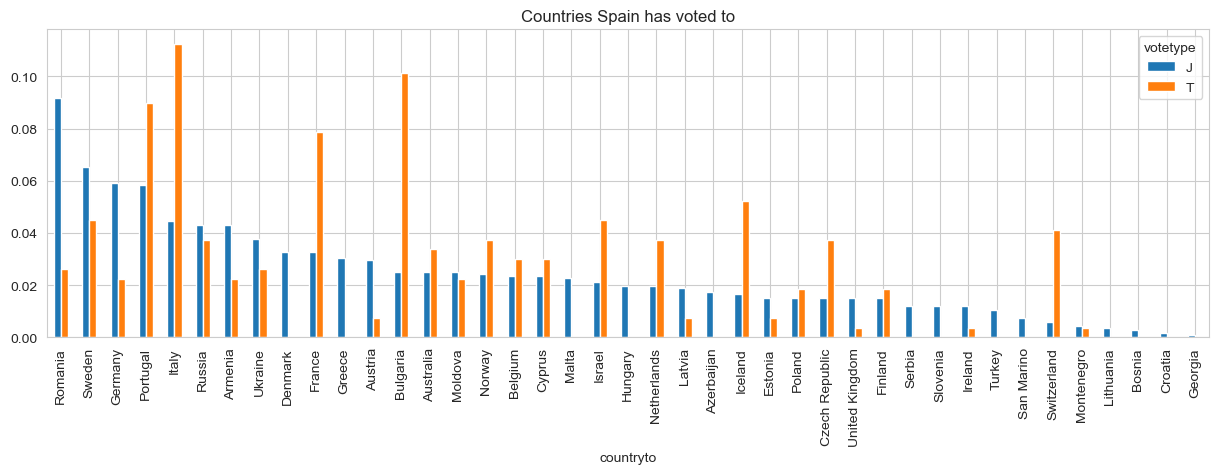

In [16]:
df2 \
    .query('year >= 2000 and countryfrom=="Spain"')\
    .pivot_table(index='countryto',columns='votetype', values='points',aggfunc='sum').fillna(0).sort_values('J',ascending=False)\
    .apply(lambda x: x/x.sum(), axis=0)\
    .plot(kind='bar',stacked=False,figsize=(15,4), title='Countries Spain has voted to');
plt.grid('off')
plt.show();

### 4. Visualización del grafo

In [17]:
# Paquetes y Librerias
import networkx as nx

In [18]:
# Funciones de selecciones de porcentaje
def selectTopN(x, column, top=3):
    x = x.sort_values(column, ascending=False).head(top)
    return x

def selectTopPercent(x, column, percent=0.2, retrieve_first=True):
    x = x.sort_values(column, ascending=False)
    cut = x[column].cumsum() / x[column].sum()
    cut = cut <= percent

    # Return at least the first and avoid warnings
    if retrieve_first and cut.sum() == 0:
        return x.iloc[0]

    return x[cut]

Visualizamos, por año en la fase final el grafo resultante de la agregacion de votos y televotos.

In [19]:
def plot_eurovision_graph(df, year, percent=0.3):
    # Agregar el televoto y el voto del jurado
    temp = df2.groupby(['year', 'final', 'countryfrom', 'countryto']).agg({'points':'sum'})\
    .reset_index().rename(columns={'points':'weight'})

    # Seleccion de fase final de un año
    df_year = temp[(temp['year'].dt.year == year) & (temp['final'] == 'f')]

    # Crear el grafo original con todas las conexiones
    G = nx.from_pandas_edgelist(df_year, 'countryfrom', 'countryto', ['weight'], create_using=nx.DiGraph)
    pos1 = nx.circular_layout(G) #layout del primer grafo

    # Crear el segundo grafo con el porcentaje de los pesos mas altos
    selected_edges = selectTopPercent(df_year, 'weight', percent=percent)
    G2 = nx.from_pandas_edgelist(selected_edges, 'countryfrom', 'countryto', ['weight'], create_using=nx.DiGraph)
    pos2 = nx.kamada_kawai_layout(G2, weight='weight') # layout del segundo grafo

    # Graficos
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Grafo original
    nx.draw(G, pos1, ax=axs[0], with_labels=True, node_color=list(nx.pagerank(G).values()),
            cmap=plt.cm.viridis_r, edge_color='#cccccc', font_color='#000', font_size=10, font_weight='bold', arrows=True)
    axs[0].set_title(f'Directed Graph of Points Exchange in Eurovision {year} (Original)')
    axs[0].axis('off')

    # Grafo con el porcentaje seleccionado
    nx.draw(G2, pos2, ax=axs[1], with_labels=True, node_color=list(nx.pagerank(G2).values()),
            cmap=plt.cm.viridis_r, edge_color='#cccccc', font_color='#000', font_size=10, font_weight='bold', arrows=True)
    axs[1].set_title(f'Directed Graph of Points Exchange in Eurovision {year} (30% of Edge Weight)')
    axs[1].axis('off')


    plt.tight_layout()
    plt.show()

    return df_year, selected_edges, G, G2

In [ ]:
# Final 2019
plot_eurovision_graph(df2, 2019, percent=0.3)

In [ ]:
# Final 2003
plot_eurovision_graph(df2, 2003, percent=0.3)

### 5. Explorción de estructuras subyacentes del grafo

**Ideas:**
1. Estático
- **Métricas para un año en concreto/lapso de tiempo:** Explora métricas como la centralidad de intermediación, la centralidad de cercanía, la centralidad de grado, la transitividad (para triadas), la distribución de grados, la longitud promedio del camino más corto, la clustering coefficient, etc. Estudiar estas métricas te dará una comprensión detallada de la estructura y la dinámica de la red en un año específico o durante un período de tiempo determinado.

- **Comparación con modelos de referencia:** Compara las métricas de tu red con las de modelos de referencia como el modelo de Erdős-Rényi (ER) o el modelo de Barabási-Albert (BA). Esto te ayudará a determinar si tu red exhibe características de redes aleatorias, redes libres de escala u otros tipos de redes.

- **Análisis de estructuras subyacentes:** Investiga las estructuras subyacentes en tu red, como los subgrafos densamente conectados, las comunidades o los patrones de triadas específicos. Identificar estas estructuras puede revelar aspectos interesantes sobre la organización y la función de la red.

2. Dinámico
- **Inferencia:** Utiliza los grafos estáticos anteriores para predecir enlaces en el siguiente año. Puedes emplear métodos de aprendizaje automático, como algoritmos de clasificación o regresión, para predecir la probabilidad de que se forme un enlace entre dos nodos en el próximo período de tiempo.

3. Centradonos en un país (España)
- **Red ego:** Crea una red ego centrada en España y analiza sus propiedades estructurales y dinámicas. Esto te permitirá entender mejor la posición de España dentro de la red más amplia y cómo interactúa con otros países específicamente en el contexto del Eurovisión.


## 1. Estático

### (A) Métricas

In [23]:
# Calcular metricas en forma de funcion
def metricas_red(df, ano):
    # Filtramos el año especifico
    df_ano, edges_ano, G_ano, Gedges_ano= plot_eurovision_graph(df2, ano, percent=0.3)
    
    # Metricas
    metrics = {}
    
    # Numero de nodos y enlaces
    metrics['nodos'] = G_ano.number_of_nodes()
    metrics['enlaces'] = G_ano.number_of_edges()
    
    # Densidad
    metrics['denisdad'] = nx.density(G_ano)
    
    # Grado de todos los nodos
    metrics['grado'] = G_ano.degree()
    # Grado promedio
    metrics['grado_promedio'] = sum(dict(G_ano.degree()).values()) / metrics['nodos']
    
    # Distribucion de grados 
    degree_sequence = [d for n, d in G_ano.degree()]
    degree_counts = nx.degree_histogram(G_ano)
    metrics['degree_distribution'] = degree_counts
    
    # Grafico distribucion de grado
    plt.figure(figsize=(8, 6))
    plt.hist(dict(G_ano.degree()).values())
    plt.title(f'Degree Distribution - Eurovision {ano}')
    plt.show()  
    
    # Caminos en el grafo
    # Componente fuertemente conectada mas grande - COMPONENTE GIGANTE
    largest_component = max(nx.strongly_connected_components(G_ano), key=len)
    metrics['G_largest'] = G_ano.subgraph(largest_component).copy()
    
    # Diametro
    metrics['diameter'] = nx.diameter(metrics['G_largest'])
    
    # Grafico de la componente gigante
    plt.figure(figsize=(8, 6))
    pos = nx.kamada_kawai_layout(metrics['G_largest'])  # You can choose any layout you prefer
    nx.draw(metrics['G_largest'], pos, with_labels=True, node_color='#87CEEB',
            edge_color='#cccccc', font_color='#000', font_size=10, font_weight='bold', arrows=True)
    plt.title(f'Largest Strongly Connected Component - Eurovision {ano}')
    plt.axis('off')
    plt.show()
    
    # Centralidad de intermediacion
    metrics['betweenness_centrality'] = nx.betweenness_centrality(G_ano)

    # Centralidad de cercania
    metrics['closeness_centrality'] = nx.closeness_centrality(G_ano)

    # Centralidad de grado
    metrics['degree_centrality'] = nx.degree_centrality(G_ano)

    # Transitividad
    metrics['transitivity'] = nx.transitivity(G_ano)
    

    # Longitud promedio del camino mas corto
    metrics['average_shortest_path_length'] = nx.average_shortest_path_length(metrics['G_largest'])

    # Coeficiente de clustering
    metrics['clustering_coefficient'] = nx.average_clustering(G_ano)
    
    # Convertir el diccionario de metricas a DataFrame
    df_metricas = pd.DataFrame.from_dict(metrics, orient='index').transpose()
    df_metricas['Año'] = ano
    
    return metrics  

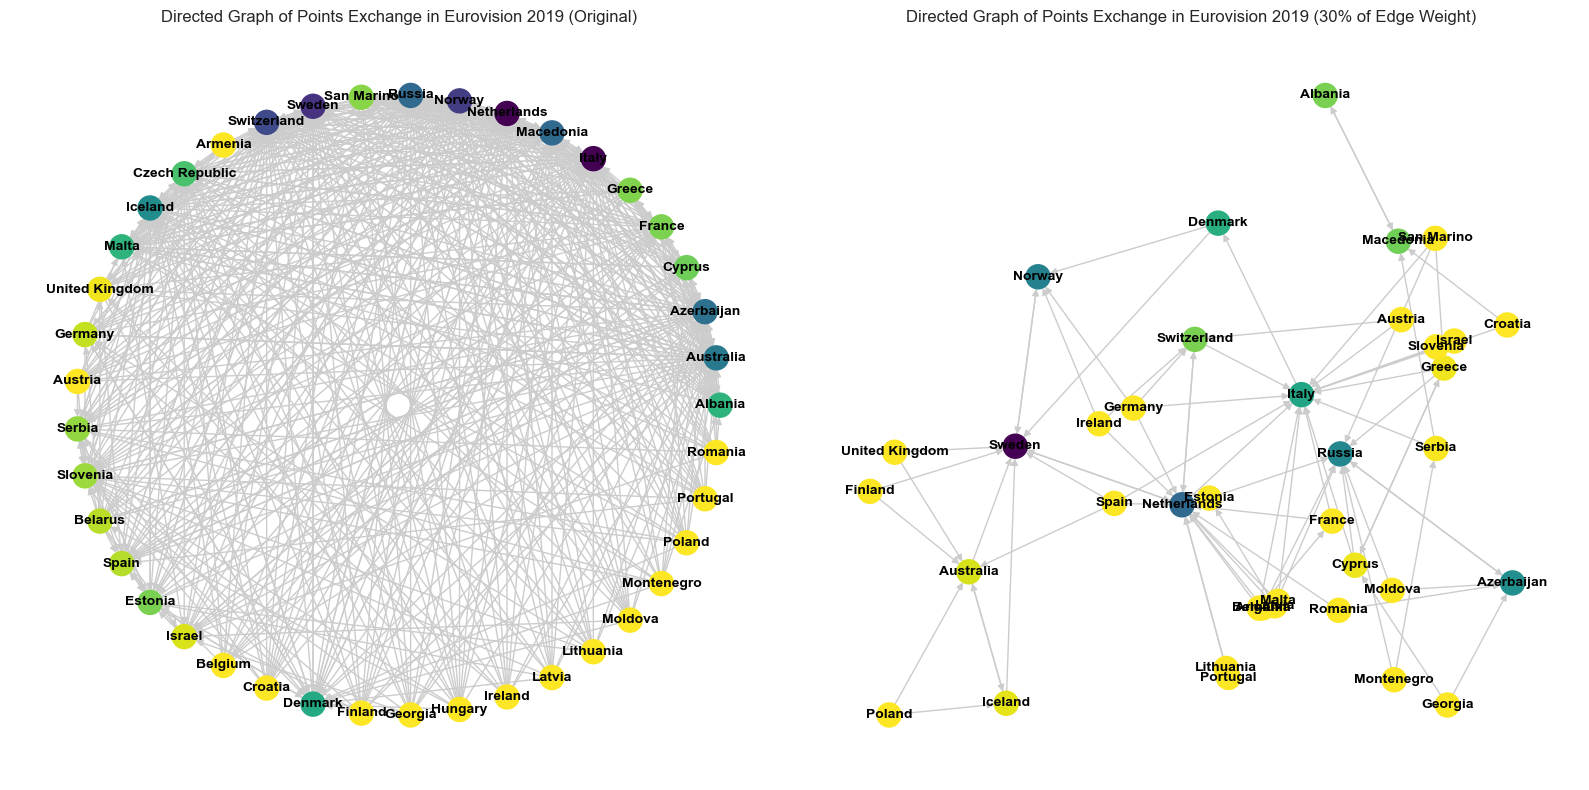

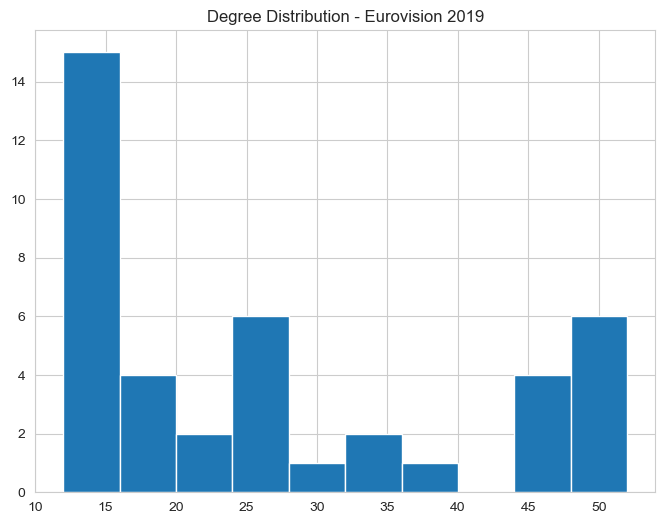

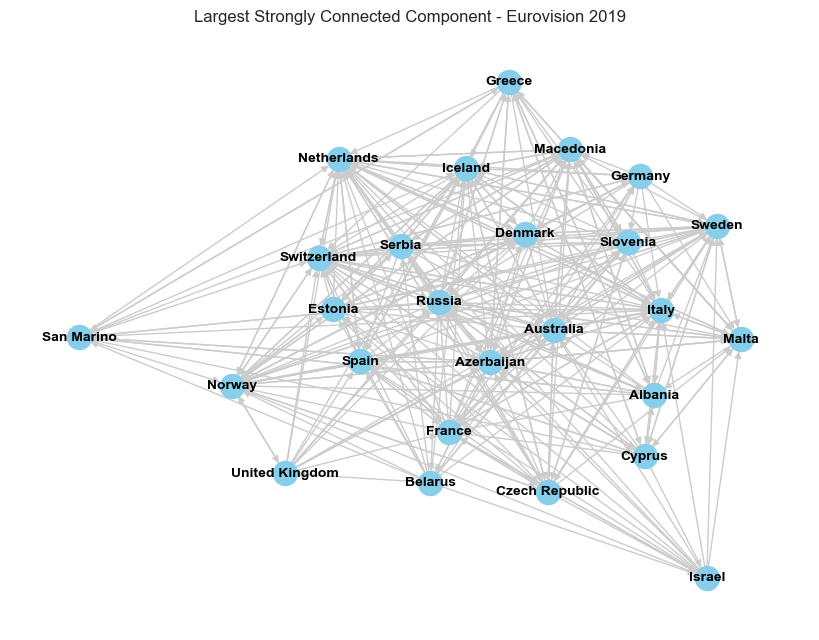

{'G_largest': <networkx.classes.digraph.DiGraph object at 0x0000023EA86C0A10>,
 'average_shortest_path_length': 1.4861538461538462,
 'betweenness_centrality': {'Albania': 0.004751693519406071,
                            'Armenia': 0.0,
                            'Australia': 0.016520201009067405,
                            'Austria': 0.0,
                            'Azerbaijan': 0.04448194546119648,
                            'Belarus': 0.004433084066181233,
                            'Belgium': 0.0,
                            'Croatia': 0.0,
                            'Cyprus': 0.009210453148965294,
                            'Czech Republic': 0.014354484921286537,
                            'Denmark': 0.006135395943088251,
                            'Estonia': 0.004167652148421379,
                            'Finland': 0.0,
                            'France': 0.011741417554929696,
                            'Georgia': 0.0,
                            'Germany': 0.00221

In [24]:
# Uso de la función para calcular metricas para el año 2019
metricas_2019 = metricas_red(df2, 2019)
pprint.pprint(metricas_2019)

In [36]:
# DISTRIBUCION DE GRADO
# Tipos de distribucion
def poisson_distribution(k, z):
    return np.exp(-z) * (z**k) / np.math.factorial(k)

def exponential_distribution(k, C, alpha):
    return C * np.exp(-alpha * k)

def power_law_distribution(k, C, gamma):
    return C * (k**(-gamma))

#### Para el año 2019 - Conceptos elementales

* El grafo tiene $n = 41$ nodos y $m = 536$ enlaces. 
* El grado medio: $\frac{2m}{n} = 26.14$
* Densidad: $\rho = \frac{m}{\binom{N}{2}} = 0.3268$; $C(41,2) = 820$
* Distribución de grados: ¿Podría ser de Poisson?
* Componente gigante:
* Diámetro compoennte gigante: 3

La propiedad de **"mundo pequeño"** en las redes se refiere a la idea de que la mayoría de los nodos pueden alcanzarse desde cualquier otro nodo a través de un número relativamente corto de pasos.

Una forma común de medir si una red es un "mundo pequeño" es calcular el coeficiente de clustering y el camino promedio más corto (o longitud media del camino) en la red. Estos son:

1. Coeficiente de Clustering: Mide cuánto tienden a agruparse los nodos vecinos de un nodo en la red. En este caso $0.58$

2. Camino Promedio Más Corto: Es la longitud promedio de los caminos más cortos entre todos los pares de nodos en la red. En este caso,  $1.48$

Luego, la red parece ser mundo pequeño.

### (B) Comparación con modelos de referencia

In [25]:
# Modelo de Erdős-Rényi (ER)
def generar_red_ER(n, p):
    return nx.erdos_renyi_graph(n, p)

# Modelo de Barabási-Albert (BA)
def generar_red_BA(n, m):
    return nx.barabasi_albert_graph(n, m)

# Función para calcular metricas de red
def calcular_metricas_red(G):
    metrics = {}

    # Calcular las métricas de interés
    metrics['nodos'] = len(G.nodes())
    metrics['enlaces'] = len(G.edges())
    metrics['grado_promedio'] = sum(dict(G.degree()).values()) / metrics['nodos']
    # Agrega más métricas según tus necesidades

    return metrics

In [26]:
# Generar redes de referencia utilizando los modelos ER y BA
red_ER = generar_red_ER(41, 2*536/(41*(41-1)))
red_BA = generar_red_BA(41,round(2*536/41))

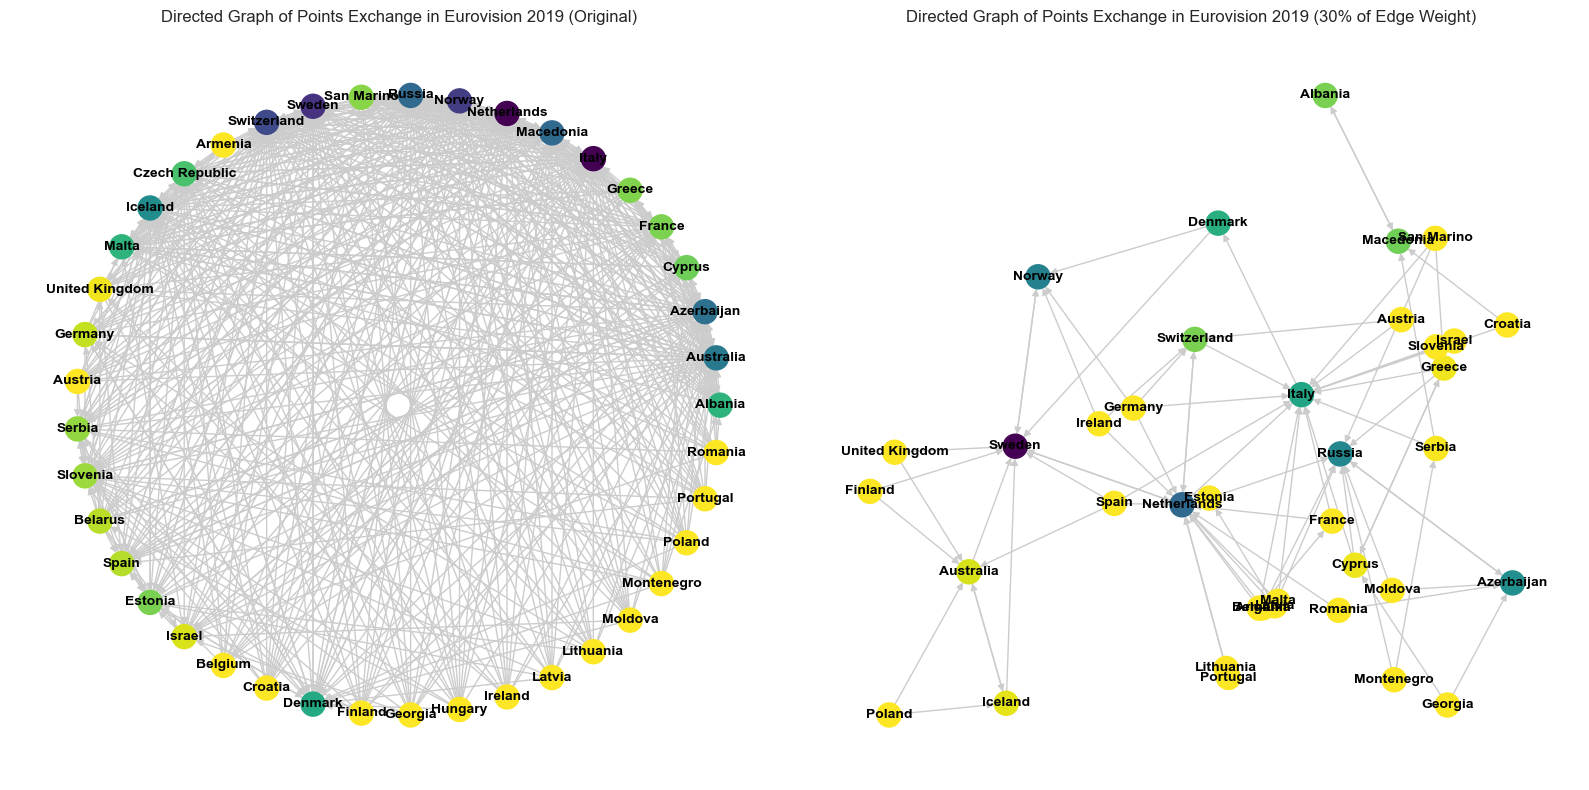

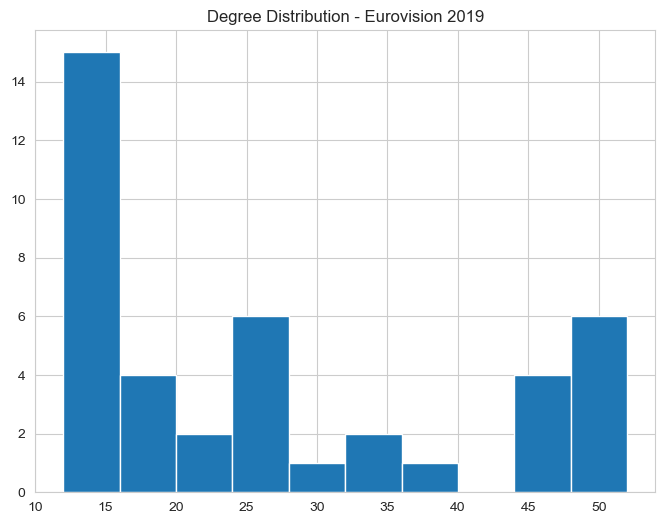

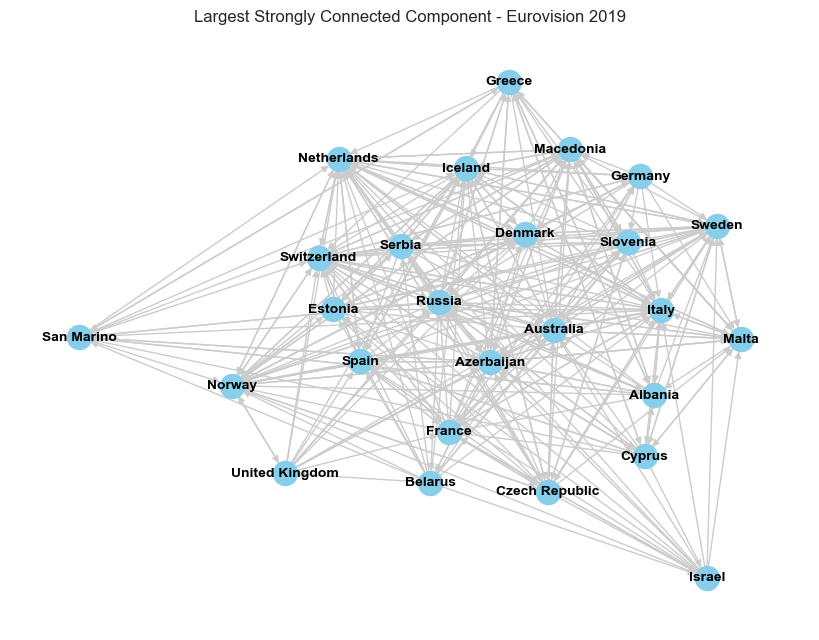

Métricas de tu red:
{'nodos': 41, 'enlaces': 536, 'denisdad': 0.32682926829268294, 'grado': DiDegreeView({'Albania': 24, 'Australia': 48, 'Azerbaijan': 49, 'Cyprus': 24, 'France': 33, 'Greece': 20, 'Italy': 51, 'Macedonia': 44, 'Netherlands': 52, 'Norway': 47, 'Russia': 50, 'San Marino': 21, 'Sweden': 44, 'Switzerland': 50, 'Armenia': 12, 'Czech Republic': 36, 'Iceland': 45, 'Malta': 27, 'United Kingdom': 17, 'Germany': 19, 'Austria': 14, 'Serbia': 27, 'Slovenia': 32, 'Belarus': 18, 'Spain': 24, 'Estonia': 24, 'Israel': 19, 'Belgium': 12, 'Croatia': 13, 'Denmark': 29, 'Finland': 13, 'Georgia': 14, 'Hungary': 15, 'Ireland': 12, 'Latvia': 13, 'Lithuania': 13, 'Moldova': 13, 'Montenegro': 13, 'Poland': 14, 'Portugal': 14, 'Romania': 13}), 'grado_promedio': 26.146341463414632, 'degree_distribution': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 4, 1, 0, 1, 1, 2, 1, 1, 0, 0, 4, 0, 0, 2, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 1, 1, 2, 1, 1], 'G_largest': <networkx.classes.d

In [27]:
# Calcular metricas para cada red
metricas_euro = metricas_red(df2, 2019)
metricas_ER = calcular_metricas_red(red_ER)
metricas_BA = calcular_metricas_red(red_BA)

# Imprimir las métricas
print("Métricas de tu red:")
print(metricas_euro)
print("\nMétricas del modelo ER:")
print(metricas_ER)
print("\nMétricas del modelo BA:")
print(metricas_BA)

### (C) Análisis de estructuras subyacentes

2. Red Ego


In [28]:
# Filtrar los datos para incluir interacciones donde España esté involucrada
spain_df = df2[(df2['countryfrom'] == 'Spain') | (df2['countryto'] == 'Spain')]

Creamos el grafo ego

In [29]:
import networkx as nx

# Crear un grafo dirigido ego centrado en España
ego_graph = nx.from_pandas_edgelist(spain_df, source='countryfrom', target='countryto', edge_attr='points', create_using=nx.DiGraph())

**Análisis de propiedades estructurales**

Centralidad de intermediación

In [30]:
betweenness_centrality = nx.betweenness_centrality(ego_graph)
betweenness_centrality

{'Spain': 0.9343434343434344,
 'France': 0.0,
 'Ireland': 0.0,
 'Italy': 0.0,
 'Belgium': 0.0,
 'Finland': 0.0,
 'Germany': 0.0,
 'Israel': 0.0,
 'Norway': 0.0,
 'Switzerland': 0.0,
 'Turkey': 0.0,
 'Macedonia': 0.0,
 'Serbia': 0.0,
 'Montenegro': 0.0,
 'Slovenia': 0.0,
 'Bosnia': 0.0,
 'Croatia': 0.0,
 'Netherlands': 0.0,
 'United Kingdom': 0.0,
 'Sweden': 0.0,
 'Portugal': 0.0,
 'Austria': 0.0,
 'Greece': 0.0,
 'Denmark': 0.0,
 'Cyprus': 0.0,
 'Iceland': 0.0,
 'Malta': 0.0,
 'Romania': 0.0,
 'Slovakia': 0.0,
 'Hungary': 0.0,
 'Poland': 0.0,
 'Estonia': 0.0,
 'Russia': 0.0,
 'Latvia': 0.0,
 'Ukraine': 0.0,
 'Belarus': 0.0,
 'Moldova': 0.0,
 'Bulgaria': 0.0,
 'Albania': 0.0,
 'Armenia': 0.0,
 'Lithuania': 0.0,
 'Georgia': 0.0,
 'Azerbaijan': 0.0,
 'San Marino': 0.0,
 'Australia': 0.0,
 'Czech Republic': 0.0}

Centralidad de cercanía

In [31]:
closeness_centrality = nx.closeness_centrality(ego_graph)
closeness_centrality

{'Spain': 0.9777777777777777,
 'France': 0.49450830140485313,
 'Ireland': 0.49450830140485313,
 'Italy': 0.49450830140485313,
 'Belgium': 0.49450830140485313,
 'Finland': 0.49450830140485313,
 'Germany': 0.49450830140485313,
 'Israel': 0.49450830140485313,
 'Norway': 0.49450830140485313,
 'Switzerland': 0.49450830140485313,
 'Turkey': 0.49450830140485313,
 'Macedonia': 0.49450830140485313,
 'Serbia': 0.49450830140485313,
 'Montenegro': 0.49450830140485313,
 'Slovenia': 0.49450830140485313,
 'Bosnia': 0.49450830140485313,
 'Croatia': 0.49450830140485313,
 'Netherlands': 0.49450830140485313,
 'United Kingdom': 0.49450830140485313,
 'Sweden': 0.49450830140485313,
 'Portugal': 0.49450830140485313,
 'Austria': 0.49450830140485313,
 'Greece': 0.49450830140485313,
 'Denmark': 0.49450830140485313,
 'Cyprus': 0.49450830140485313,
 'Iceland': 0.49450830140485313,
 'Malta': 0.49450830140485313,
 'Romania': 0.49450830140485313,
 'Slovakia': 0.49450830140485313,
 'Hungary': 0.49450830140485313,
 'P

Centralidad de grado

In [32]:
degree_centrality = nx.degree_centrality(ego_graph)
degree_centrality

{'Spain': 1.9333333333333333,
 'France': 0.044444444444444446,
 'Ireland': 0.044444444444444446,
 'Italy': 0.044444444444444446,
 'Belgium': 0.044444444444444446,
 'Finland': 0.044444444444444446,
 'Germany': 0.044444444444444446,
 'Israel': 0.044444444444444446,
 'Norway': 0.044444444444444446,
 'Switzerland': 0.044444444444444446,
 'Turkey': 0.044444444444444446,
 'Macedonia': 0.044444444444444446,
 'Serbia': 0.044444444444444446,
 'Montenegro': 0.044444444444444446,
 'Slovenia': 0.044444444444444446,
 'Bosnia': 0.044444444444444446,
 'Croatia': 0.044444444444444446,
 'Netherlands': 0.044444444444444446,
 'United Kingdom': 0.044444444444444446,
 'Sweden': 0.044444444444444446,
 'Portugal': 0.044444444444444446,
 'Austria': 0.044444444444444446,
 'Greece': 0.044444444444444446,
 'Denmark': 0.044444444444444446,
 'Cyprus': 0.044444444444444446,
 'Iceland': 0.044444444444444446,
 'Malta': 0.044444444444444446,
 'Romania': 0.044444444444444446,
 'Slovakia': 0.044444444444444446,
 'Hungar

Trasitividad

In [33]:
transitivity = nx.transitivity(ego_graph)
transitivity

0

Distribución de grados

In [34]:
degree_distribution = list(nx.degree_histogram(ego_graph))
degree_distribution

[0,
 3,
 42,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

Visualización

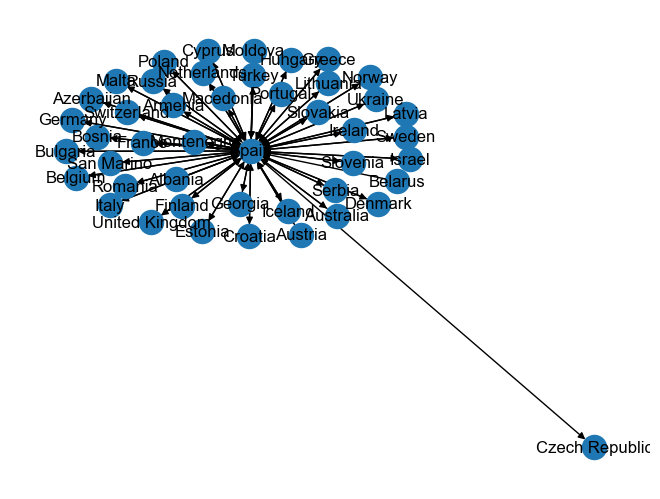

In [35]:
import matplotlib.pyplot as plt

# Visualizar el grafo ego centrado en España
nx.draw(ego_graph, with_labels=True)
plt.show()

In [ ]:
# Crear una red ego centrada en España
def create_ego_network(data, center_country):
    # Filtrar los datos para obtener solo las interacciones relacionadas con el país central
    ego_data = data[(data['countryfrom'] == center_country) | (data['countryto'] == center_country)]

    # Crear un grafo dirigido
    G = nx.DiGraph()

    # Agregar nodos y aristas al grafo
    for idx, row in ego_data.iterrows():
        G.add_edge(row['countryfrom'], row['countryto'], weight=row['points'])

    return G

# Crear la red ego centrada en España
ego_network = create_ego_network(df2, 'Spain')

# Propiedades estructurales
print("Número de nodos en la red ego centrada en España:", ego_network.number_of_nodes())
print("Número de aristas en la red ego centrada en España:", ego_network.number_of_edges())

# Propiedades dinámicas
print("Coeficiente de clustering promedio de la red ego centrada en España:", nx.average_clustering(ego_network))
print("Grado promedio de los nodos en la red ego centrada en España:", sum(dict(ego_network.degree()).values()) / ego_network.number_of_nodes())

# Visualizar la red ego centrada en España
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(ego_network)
nx.draw(ego_network, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray', linewidths=1, font_size=10)
plt.title('Red ego centrada en España')
plt.show()
